# FIntune SAM on confocal plant root images

In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /localscratch-ssd/242260/pip-req-build-gbf710j1
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=29caac5341c9704a337eddf0130c030c039bf3cfe12aa8280139d289750d2470
  Stored in directory: /localscratch-ssd/242260/pip-ephem-wheel-cache-_44qfra7/wheels/b0/7e/40/20f0b1e23280cc4a66dc8009c29f42cb4afc1b205bc5814786
Successfully built segment-anything
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tokenizers 0.14.1 requires huggingface_hub<

In [ ]:
# !pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 61.7 MB 3.4 MB/s eta 0:00:01     |███████████████████████████▌    | 53.1 MB 3.4 MB/s eta 0:00:03


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageStat
from skimage import io, util, color, transform
from scipy.optimize import linear_sum_assignment
import sys
import cv2
import pickle

Load data into numpy arrays.

In [ ]:
images = []
masks = []

for i, row in df.iterrows():
  # for img in range(large_images.shape[0]):
      image = io.imread(row['Original'])
      if image.shape[2] > 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (1024, 1024))
      with open(row['mask_pickle'], "rb") as file:
        loaded_masks = pickle.load(file)
        print(row['mask_pickle'])
      for mask in loaded_masks:
        mask = cv2.resize(mask.astype(np.uint8), (1024, 1024))
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        # mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        masks.append(mask)
        images.append(image)


/content/drive/MyDrive/mask_sam_filtered/masks5.pkl
/content/drive/MyDrive/mask_sam_filtered/masks6.pkl
/content/drive/MyDrive/mask_sam_filtered/masks7.pkl
/content/drive/MyDrive/mask_sam_filtered/masks8.pkl
/content/drive/MyDrive/mask_sam_filtered/masks9.pkl
/content/drive/MyDrive/mask_sam_filtered/masks10.pkl
/content/drive/MyDrive/mask_sam_filtered/masks11.pkl
/content/drive/MyDrive/mask_sam_filtered/masks12.pkl
/content/drive/MyDrive/mask_sam_filtered/masks13.pkl
/content/drive/MyDrive/mask_sam_filtered/masks14.pkl
/content/drive/MyDrive/mask_sam_filtered/masks15.pkl
/content/drive/MyDrive/mask_sam_filtered/masks17.pkl
/content/drive/MyDrive/mask_sam_filtered/masks18.pkl
/content/drive/MyDrive/mask_sam_filtered/masks19.pkl
/content/drive/MyDrive/mask_sam_filtered/masks20.pkl
/content/drive/MyDrive/mask_sam_filtered/masks21.pkl
/content/drive/MyDrive/mask_sam_filtered/masks23.pkl


In [ ]:
with open(f"/content/drive/MyDrive/masks_train.pkl", 'wb') as file:
  pickle.dump(masks, file)
with open(f"/content/drive/MyDrive/images_train.pkl", 'wb') as file:
  pickle.dump(images, file)

In [ ]:
with open(f"masks_train.pkl", 'rb') as file:
  masks = pickle.load(file)
with open(f"images_train.pkl", 'rb') as file:
  images = pickle.load(file)


In [ ]:
images_arr = np.array(images)
masks_arr = np.array(masks)
# images = np.squeeze(images, axis=1)
# masks = np.squeeze(masks, axis=1)

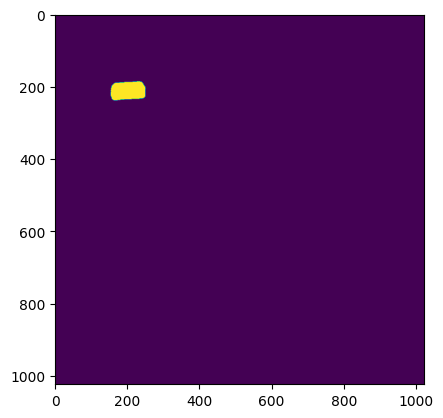

In [ ]:
plt.imshow(masks_arr[2])

Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images_arr],
    "label": [Image.fromarray(mask) for mask in masks_arr],
}

# Create the dataset using the datasets.Dataset class
# dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2526
})

In [ ]:
dataset.save_to_disk("/content/drive/MyDrive/sam_dataset")

Saving the dataset (0/4 shards):   0%|          | 0/2526 [00:00<?, ? examples/s]

In [ ]:
loaded_dataset = Dataset.load_from_disk("/content/drive/MyDrive/sam_dataset")


Let us make sure out images and masks (labels) are loading appropriately

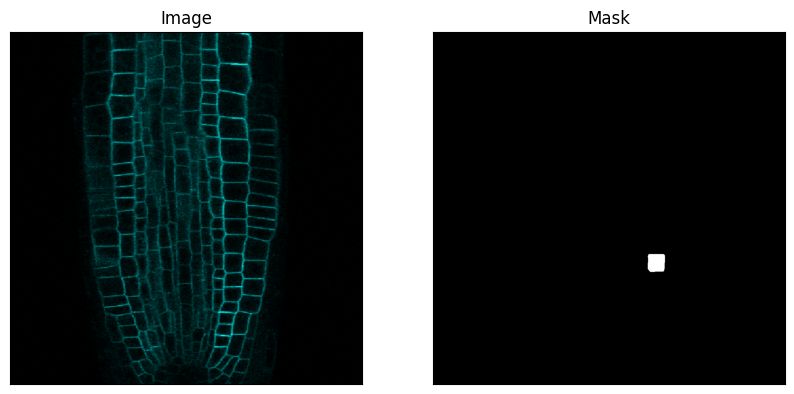

In [ ]:
img_num = random.randint(0, images_arr.shape[0]-1)
example_image = loaded_dataset[img_num]["image"]
example_mask = loaded_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [ ]:
#Get bounding boxes from mask.
###### ? check the masks for the patches to see if there are more than 1 object
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  # ground_truth_map = cv2.cvtColor(ground_truth_map, cv2.COLOR_BGR2GRAY)
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]
  ground_truth_map = cv2.cvtColor(ground_truth_map, cv2.COLOR_GRAY2BGR)
  return bbox

In [ ]:
bbcoords = []
for mask in masks:
  bbcoords.append(get_bounding_box(np.array(mask)))


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


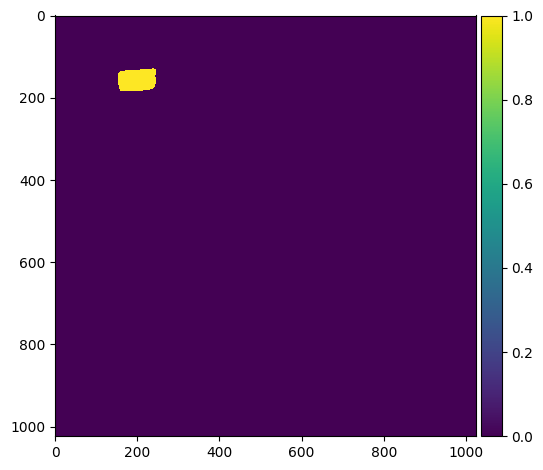

In [ ]:
io.imshow(masks[0])

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=loaded_dataset, processor=processor)

In [ ]:
# print the bounding  box coordinates

get_bounding_box(np.array(example_mask))


[623, 634, 674, 707]

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (1024, 1024)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 1024, 1024])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 1024, 1024])

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder"):
    param.requires_grad_(False)
  if name.startswith("prompt_encoder"):
    param.requires_grad_(True)
  # if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
  #   param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize, interpolate
#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1).squeeze(1)

      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      ground_truth_masks = ground_truth_masks[:, :, :]  # Extract the first channel from the RGB mask
      target_size = (2, ground_truth_masks.size(1), ground_truth_masks.size(2))
      predicted_masks_resized = interpolate(predicted_masks.unsqueeze(0).unsqueeze(0), size=target_size, mode='nearest')
      predicted_masks_resized = predicted_masks_resized.squeeze(0).squeeze(0)

      # Display the predicted masks
      # for i in range(len(predicted_masks)):
      #     plt.figure()
      #     plt.subplot(1, 2, 1)
      #     plt.imshow(ground_truth_masks[i].cpu().numpy(), cmap='gray')
      #     plt.title('Ground Truth Mask')

      #     plt.subplot(1, 2, 2)
      #     plt.imshow(predicted_masks[i].detach().cpu().numpy(), cmap='gray')
      #     plt.title('Predicted Mask')
      #     plt.show()

      loss = seg_loss(predicted_masks_resized, ground_truth_masks)
      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


100%|██████████| 1263/1263 [22:59<00:00,  1.09s/it]


EPOCH: 0
Mean loss: 9.522333828966861


100%|██████████| 1263/1263 [22:34<00:00,  1.07s/it]


EPOCH: 1
Mean loss: 9.293095516054194


100%|██████████| 1263/1263 [22:34<00:00,  1.07s/it]


EPOCH: 2
Mean loss: 9.277760152673306


100%|██████████| 1263/1263 [22:35<00:00,  1.07s/it]


EPOCH: 3
Mean loss: 9.239604383541872


100%|██████████| 1263/1263 [22:33<00:00,  1.07s/it]


EPOCH: 4
Mean loss: 9.23577133687073


100%|██████████| 1263/1263 [22:30<00:00,  1.07s/it]


EPOCH: 5
Mean loss: 9.236599762573755


100%|██████████| 1263/1263 [22:31<00:00,  1.07s/it]


EPOCH: 6
Mean loss: 9.224442121629572


100%|██████████| 1263/1263 [22:30<00:00,  1.07s/it]


EPOCH: 7
Mean loss: 9.206458293910265


100%|██████████| 1263/1263 [22:30<00:00,  1.07s/it]


EPOCH: 8
Mean loss: 9.209770552619336


100%|██████████| 1263/1263 [22:31<00:00,  1.07s/it]

EPOCH: 9
Mean loss: 9.206345976201296


In [ ]:
  # Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/sam_ft_V3_checkpoint.pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/sam_ft_V3_checkpoint.pth"))

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

# Improved Prompt Engineering after Finetuning SAM

In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 8.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.9 MB/s eta 0:00:00


In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
from ipywidgets import widgets
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget # Adjust the figure size as needed

# plt.imshow(annotated_image, cmap='gray')  # Replace 'gray' with the appropriate colormap

widget = BBoxWidget()
widget.image = encode_image("/content/10.png")
# widget.image = encode_image("/content/drive/MyDrive/consolidated_images/6.png")
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

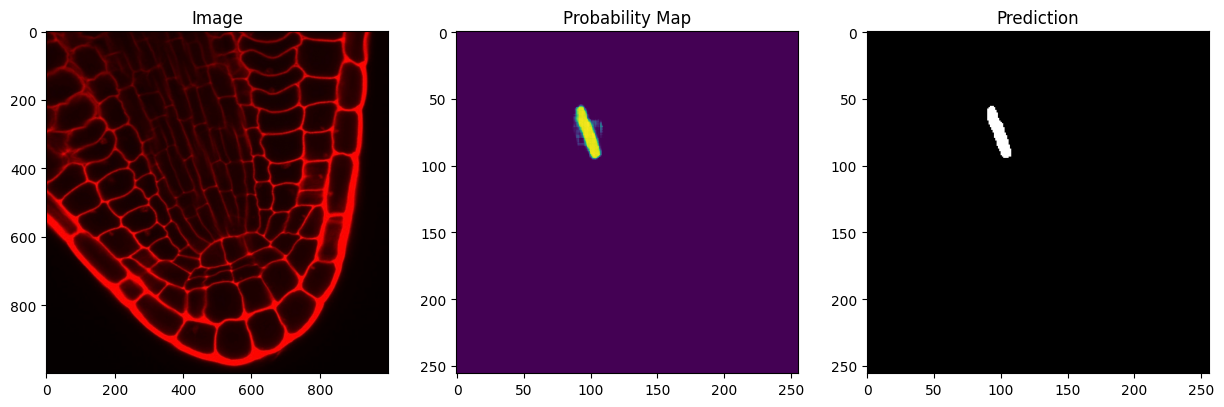

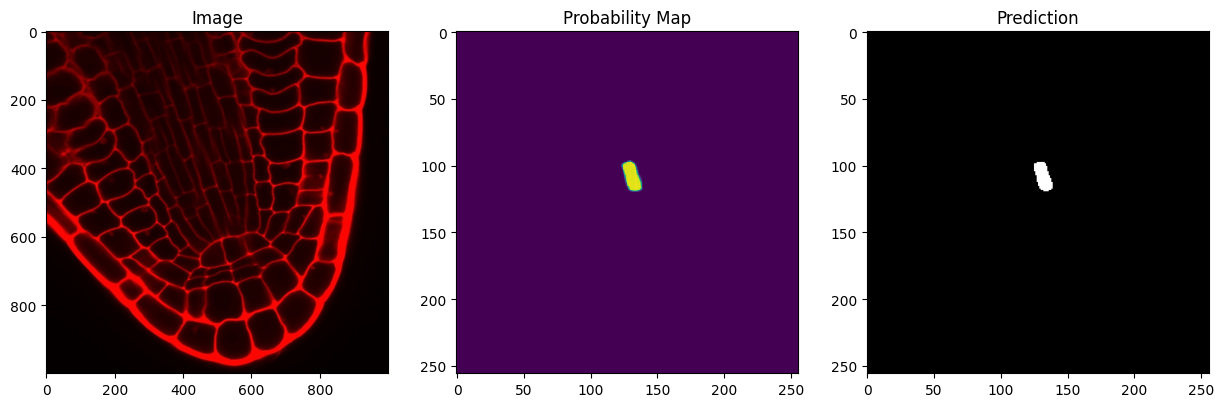

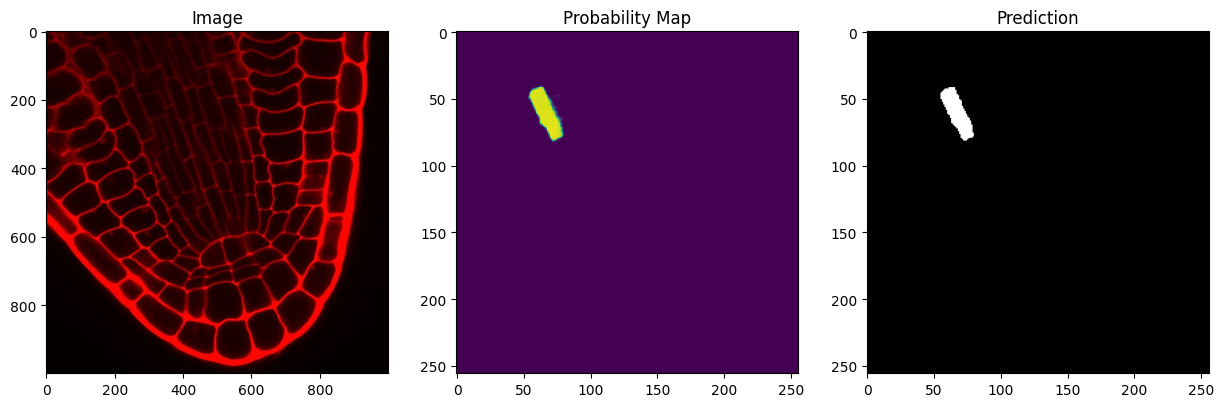

In [ ]:
for i in range(len(widget.bboxes)):
  box = widget.bboxes[i]
  box = [
      box['x'],
      box['y'],
      box['x'] + box['width'],
      box['y'] + box['height']
  ]

  test_image = io.imread('/content/10.png')

  single_patch = Image.fromarray(test_image)
  # prepare image for the model

  #First try without providing any prompt (no bounding box or input_points)
  # inputs = processor(single_patch, return_tensors="pt")
  #Now try with bounding boxes. Remember to uncomment.
  inputs = processor(single_patch, input_boxes=[[box]], return_tensors="pt")

  # Move the input tensor to the GPU if it's not already there
  inputs = {k: v.to(device) for k, v in inputs.items()}
  my_mito_model.eval()
  # forward pass
  with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

  # apply sigmoid
  single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
  single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot the first image on the left
  axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
  axes[1].set_title("Probability Map")

  # Plot the second image on the right
  axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
  axes[2].set_title("Prediction")

  plt.show()